In [37]:
import numpy as np
from scipy import integrate
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import norm

In [38]:
# 定义概率分布类
class Distribution:
    """概率分布基类"""

    def pdf(self, x):
        """概率密度函数"""
        pass

    def cdf(self, x):
        """累积分布函数"""
        pass


class UniformDistribution(Distribution):
    """均匀分布"""

    def __init__(self, a, b):
        self.a = a  # 下限
        self.b = b  # 上限

    def pdf(self, x):
        if isinstance(x, (int, float)):
            return 1 / (self.b - self.a) if self.a <= x <= self.b else 0
        else:  # 处理数组输入
            result = np.zeros_like(x, dtype=float)
            mask = (x >= self.a) & (x <= self.b)
            result[mask] = 1 / (self.b - self.a)
            return result

    def cdf(self, x):
        if isinstance(x, (int, float)):
            if x < self.a:
                return 0
            elif x > self.b:
                return 1
            else:
                return (x - self.a) / (self.b - self.a)
        else:  # 处理数组输入
            result = np.zeros_like(x, dtype=float)
            mask1 = (x < self.a)
            mask2 = (x > self.b)
            mask3 = ~(mask1 | mask2)
            result[mask2] = 1
            result[mask3] = (x[mask3] - self.a) / (self.b - self.a)
            return result


class InverseGaussianDistribution(Distribution):
    """反高斯分布"""

    def __init__(self, mu, loc, scale):
        self.mu = mu  # 均值参数
        self.loc = loc  # 位置参数
        self.scale = scale  # 尺度参数

    def pdf(self, x):
        """概率密度函数"""
        if isinstance(x, (int, float)):
            # 调整位置参数
            x_adj = x - self.loc
            if x_adj <= 0:  # 反高斯分布只在正实数上有定义
                return 0
            else:
                # 反高斯分布的PDF公式
                lambda_param = self.scale
                mu = self.mu
                return np.sqrt(lambda_param / (2 * np.pi * x_adj ** 3)) * np.exp(
                    -lambda_param * (x_adj - mu) ** 2 / (2 * mu ** 2 * x_adj)
                )
        else: 
            result = np.zeros_like(x, dtype=float)
            x_adj = x - self.loc
            mask = (x_adj > 0)  # 只在正实数上有定义

            lambda_param = self.scale
            mu = self.mu

            # 使用向量化操作计算PDF
            valid_x = x_adj[mask]
            result[mask] = np.sqrt(lambda_param / (2 * np.pi * valid_x ** 3)) * np.exp(
                -lambda_param * (valid_x - mu) ** 2 / (2 * mu ** 2 * valid_x)
            )
            return result

    def cdf(self, x):
        """累积分布函数"""
        if isinstance(x, (int, float)):
            # 调整位置参数
            x_adj = x - self.loc
            if x_adj <= 0:
                return 0
            else:
                # 反高斯分布的CDF公式
                lambda_param = self.scale
                mu = self.mu

                # 计算CDF的两个部分
                term1 = norm.cdf(np.sqrt(lambda_param / x_adj) * (x_adj / mu - 1))
                term2 = np.exp(2 * lambda_param / mu) * norm.cdf(-np.sqrt(lambda_param / x_adj) * (x_adj / mu + 1))

                return term1 + term2
        else:  # 处理数组输入
            result = np.zeros_like(x, dtype=float)
            x_adj = x - self.loc
            mask = (x_adj > 0)

            lambda_param = self.scale
            mu = self.mu

            # 使用向量化操作计算CDF
            valid_x = x_adj[mask]
            term1 = norm.cdf(np.sqrt(lambda_param / valid_x) * (valid_x / mu - 1))
            term2 = np.exp(2 * lambda_param / mu) * norm.cdf(-np.sqrt(lambda_param / valid_x) * (valid_x / mu + 1))

            result[mask] = term1 + term2
            return result
        

class GPDistribution(Distribution):
    """广义帕累托分布"""

    def __init__(self, k, sigma, mu):
        self.k = k  # 形状参数
        self.sigma = sigma  # 尺度参数
        self.mu = mu  # 位置参数

    def pdf(self, x):
        if isinstance(x, (int, float)):
            if x < self.mu:
                return 0
            else:
                z = (x - self.mu) / self.sigma
                return (1 / self.sigma) * (1 + self.k * z) ** (-1 - 1 / self.k)
        else:  # 处理数组输入
            result = np.zeros_like(x, dtype=float)
            mask = (x >= self.mu)
            z = np.zeros_like(x, dtype=float)
            z[mask] = (x[mask] - self.mu) / self.sigma
            result[mask] = (1 / self.sigma) * (1 + self.k * z[mask]) ** (-1 - 1 / self.k)
            return result

    def cdf(self, x):
        if isinstance(x, (int, float)):
            if x < self.mu:
                return 0
            else:
                z = (x - self.mu) / self.sigma
                return 1 - (1 + self.k * z) ** (-1 / self.k)
        else:  # 处理数组输入
            result = np.zeros_like(x, dtype=float)
            mask = (x >= self.mu)
            z = np.zeros_like(x, dtype=float)
            z[mask] = (x[mask] - self.mu) / self.sigma
            result[mask] = 1 - (1 + self.k * z[mask]) ** (-1 / self.k)
            return result

In [39]:
T = 15
uniform_dist = UniformDistribution(0, T)
gp_dist = GPDistribution(2.303222283978614, 0.0006999999450553588, 6.46994771277096)
# 反高斯分布的参数
invgauss_dist = InverseGaussianDistribution(40.69, -0.97, 4.87)  # mu, loc, scale


In [40]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

FILE_PATH = '分布拟合/flood_CHA.csv'
COLUMN_TO_FIT = 'Total Affected'
PERCENTILE_THRESHOLD = 0.95


df = pd.read_csv(FILE_PATH)
print(f"成功加载文件: {FILE_PATH}")

data_series = df[COLUMN_TO_FIT].copy()
data_series_numeric = pd.to_numeric(data_series, errors='coerce')

nan_count = data_series_numeric.isnull().sum()
if nan_count > 0:
    data_series_numeric.dropna(inplace=True)

if data_series_numeric.empty:
    exit()

original_count = len(data_series_numeric)
data_positive = data_series_numeric[data_series_numeric > 0]
removed_zeros_negatives = original_count - len(data_positive)

if data_positive.empty:
   exit()

print(f"\n用于计算百分位数的正数据点数量: {len(data_positive)}")

if len(data_positive) < 2:
    data_to_fit = data_positive.copy()
else:
    cutoff_value = data_positive.quantile(PERCENTILE_THRESHOLD)
    data_to_fit = data_positive[data_positive <= cutoff_value].copy()
    num_removed_by_percentile = len(data_positive) - len(data_to_fit)

data_to_fit = data_to_fit/10000
print(data_to_fit)

data_to_fit = data_to_fit[data_to_fit <= 20]

成功加载文件: 分布拟合/flood_CHA.csv

用于计算百分位数的正数据点数量: 263
0       300.0000
1        63.5000
2       360.0000
3      1003.0000
4      1000.0000
         ...    
258      13.4000
259      11.0006
260       0.7000
261       0.2700
262       0.0939
Name: Total Affected, Length: 249, dtype: float64


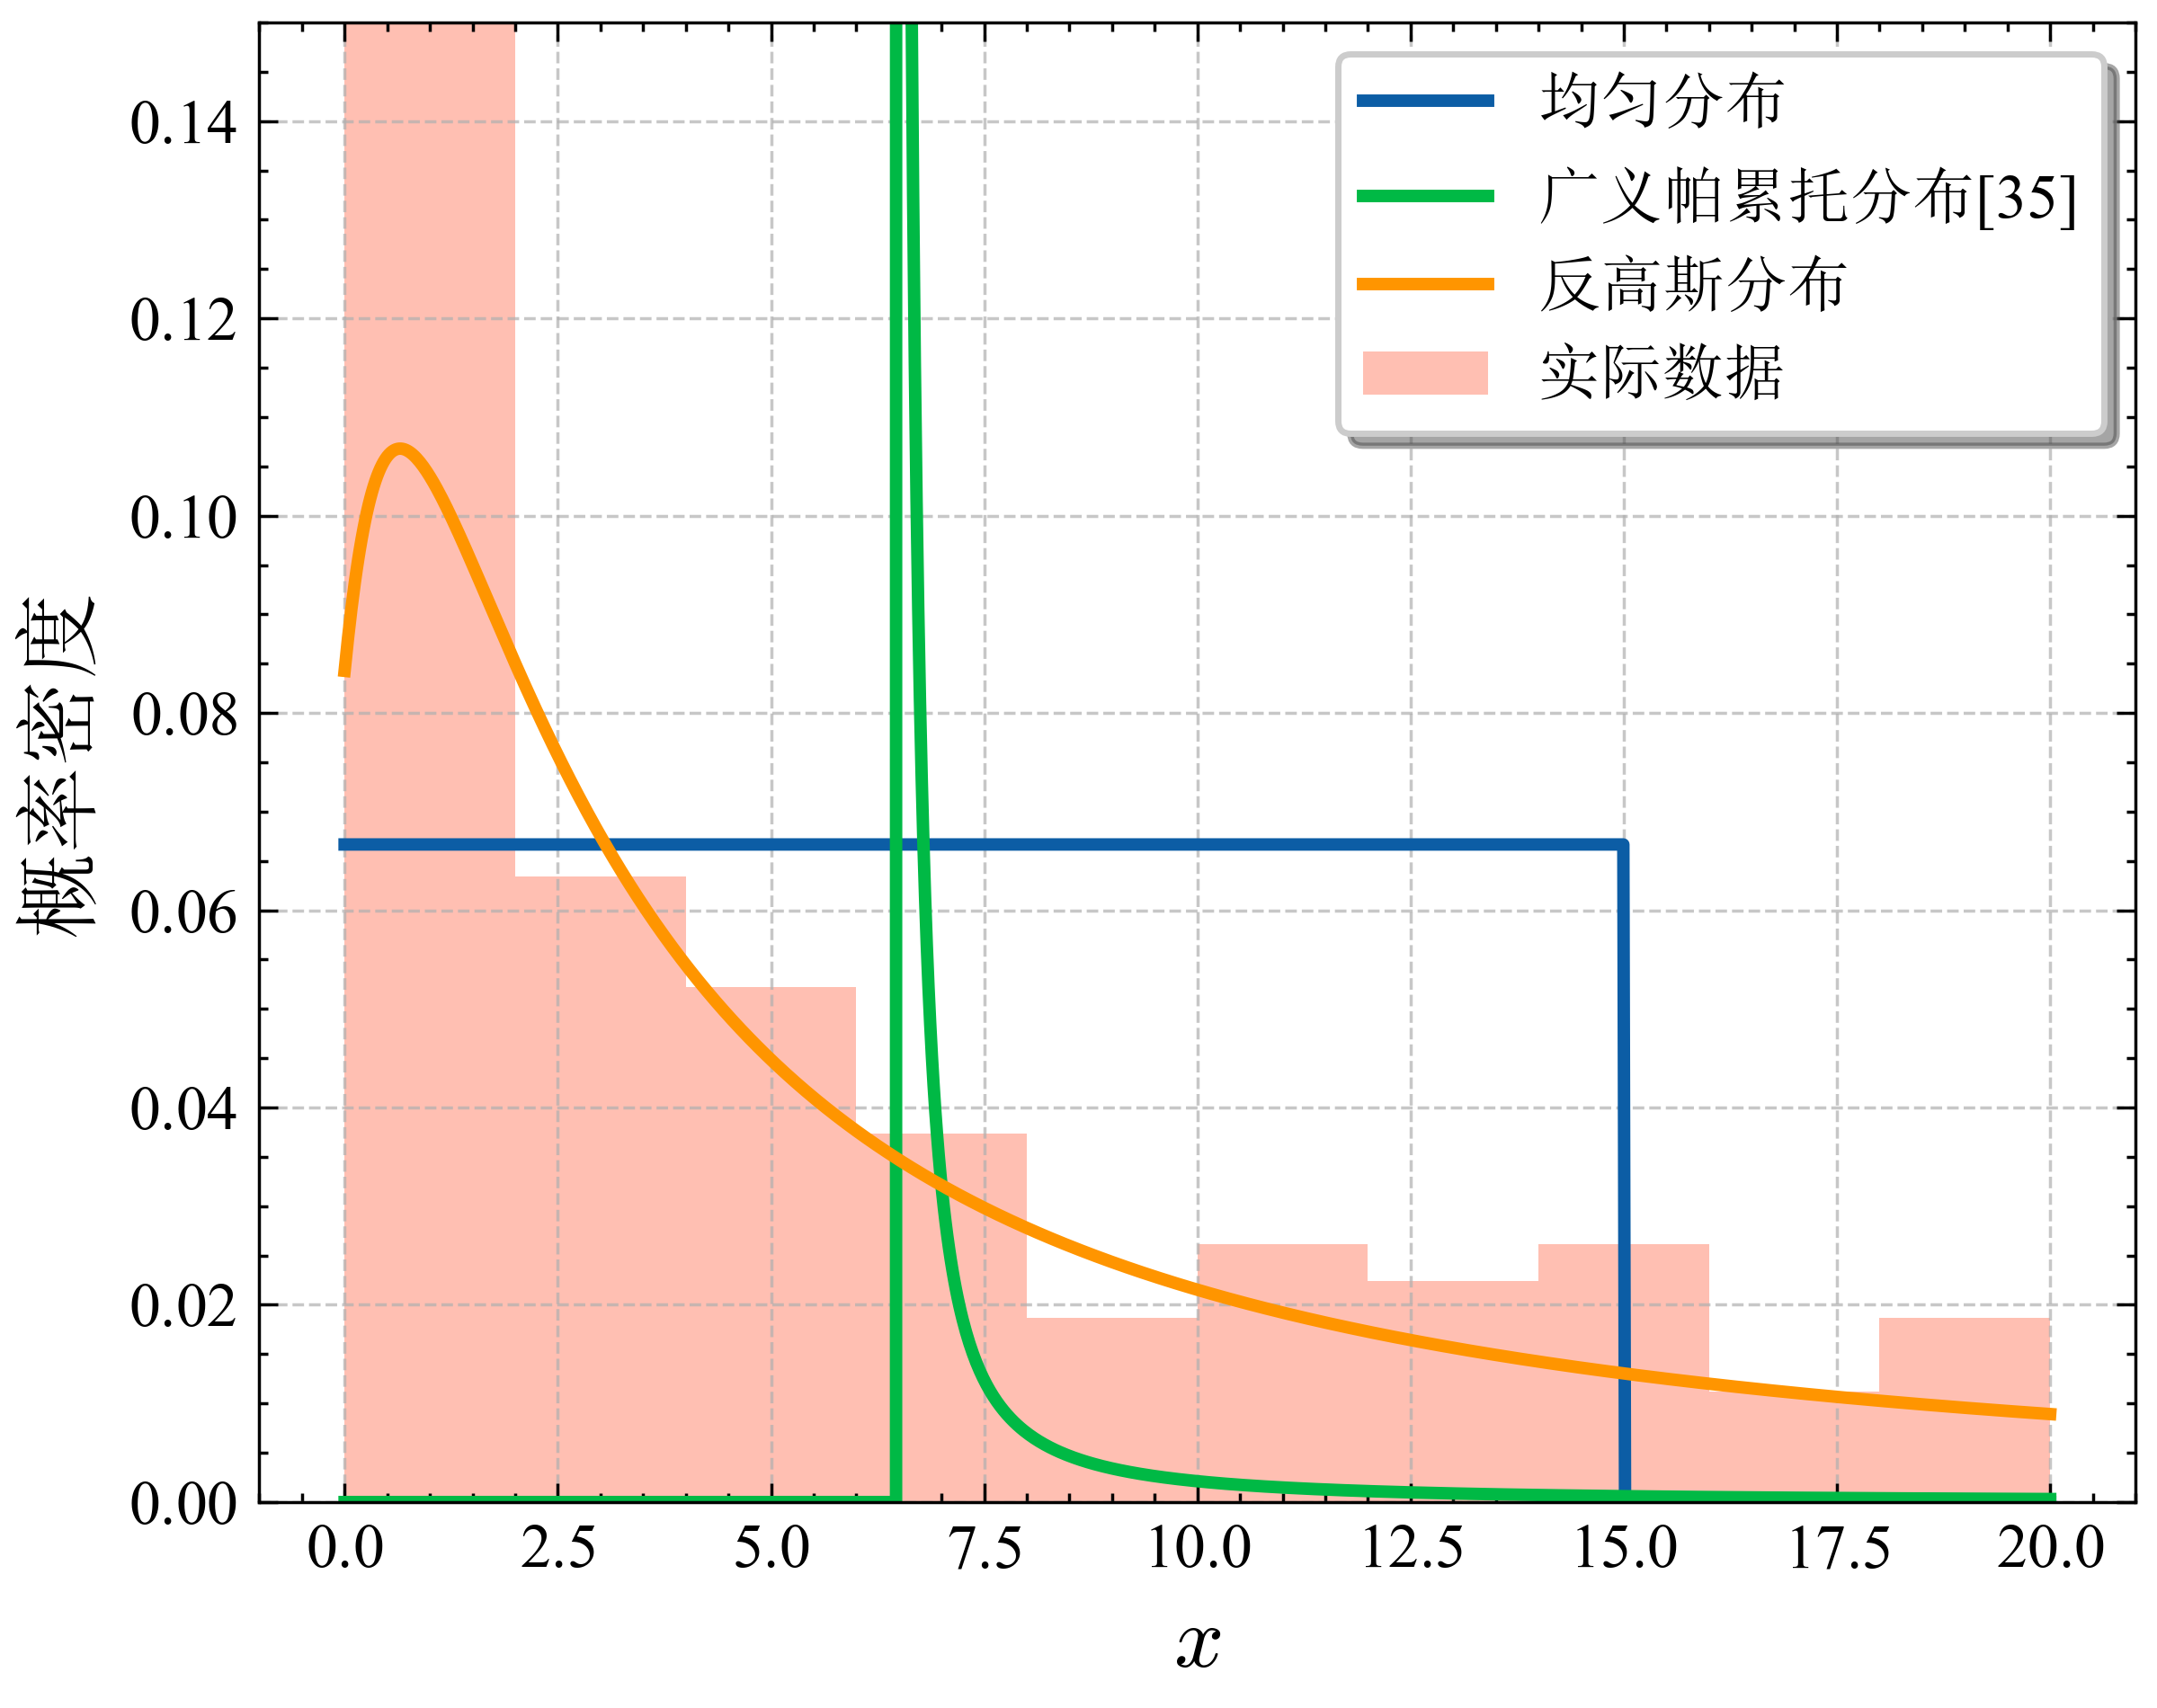

In [49]:
import scienceplots
plt.style.use(['science','no-latex'])  # 使用scienceplots样式

from mplfonts import use_font
from matplotlib import font_manager
from matplotlib import rcParams
font_path = "tnw+simsun.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
rcParams['font.family'] = 'sans-serif' # 使用字体中的无衬线体
rcParams['font.sans-serif'] = prop.get_name()  # 根据名称设置字体
rcParams['axes.unicode_minus'] = False # 使坐标轴刻度标签正常显示正负号

# 创建x值范围用于绘图
x = np.linspace(0, 20, 1000)
# 计算每个分布的PDF
uniform_pdf = uniform_dist.pdf(x)
gp_pdf = gp_dist.pdf(x)
invgauss_pdf = invgauss_dist.pdf(x)
# 创建绘图
plt.figure(figsize=(5, 4), dpi=500)
# 绘制PDF
plt.plot(x, uniform_pdf, linewidth=2, label='均匀分布')
plt.plot(x, gp_pdf,  linewidth=2, label='广义帕累托分布[35]')
plt.plot(x, invgauss_pdf,  linewidth=2, label='反高斯分布')

# 绘制实际数据的直方图
hist, bins, _ = plt.hist(data_to_fit, bins=10, density=True, alpha=0.3, label='实际数据')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel('概率密度', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
# 调整y轴范围以便更好地显示分布
plt.ylim(0, 0.15)
plt.legend(loc='best', frameon=True, shadow=True)

# 显示图表
plt.tight_layout()
plt.show()